# Poem Generation using FastAI


In this tutorial you will see how to fine-tune a pretrained transformer model from the transformers library by HuggingFace. It can be very simple with FastAI's data loaders. It's possible to use any of the pretrained models from HuggingFace. Below we will experiment with GPT2. 

## Import Libraries


In [1]:
# install fastai and log into google drive
!pip install -Uqq fastbook
!pip install -Uq transformers
import fastbook
fastbook.setup_book()


In [2]:
from fastbook import *
from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [3]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

## Read Data
This data is organized by folder. There are two main folders: forms (e.g. haiku, sonnet, etc.) and topics (e.g. love, peace, etc.). Those main folders contain subfolders for the subcategories and then the poem txt files are contained in those.
With fastai, it's quite easy to read the data with the the get_text_files function. You can select all folders or select specific ones.

In [4]:
path = '/content/gdrive/My Drive/data/poems'

In [6]:
poems = get_text_files(path, folders = ['forms','topics'])
print("There are",len(poems),"poems in the dataset")

There are 20657 poems in the dataset


We'll start off with training the model on ballads. There are only 100 ballads so it won't take as long to train. However you can add more poem forms. For instance, a haiku would be very cool to experiment with and to see if it maintains the 5,7,5 syllable structure.

In [7]:
ballads = get_text_files(path+'/forms', folders = ['ballad'])
print("There are",len(ballads),"ballads in the dataset")

There are 100 ballads in the dataset


In [8]:
txt = poems[0].open().read(); #read the first file
print(txt)

Little maidens, when you look
On this little story-book,
Reading with attentive eye
Its enticing history,
Never think that hours of play
Are your only HOLIDAY,
And that in a HOUSE of joy
Lessons serve but to annoy:
If in any HOUSE you find
Children of a gentle mind,
Each the others pleasing ever--
Each the others vexing never--
Daily work and pastime daily
In their order taking gaily--
Then be very sure that they
Have a life of HOLIDAY.


## Prepare the Data



In [9]:
ballads = L(o.open().read() for o in ballads) # to make things easy we will gather all texts in one numpy array

In [10]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt
  
all_ballads = flatten(ballads)

In [11]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [12]:
splits = [range_of(70), range(100)] # use a 70/30 split
tls = TfmdLists(all_ballads, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [13]:
show_at(tls.train, 0)

The ring is on my hand,
And the wreath is on my brow;
Satin and jewels grand
Are all at my command,
And I am happy now.
And my lord he loves me well;
But, when first he breathed his vow,
I felt my bosom swell-
For the words rang as a knell,
And the voice seemed his who fell
In the battle down the dell,
And who is happy now.
But he spoke to re-assure me,
And he kissed my pallid brow,
While a reverie came o'er me,
And to the church-yard bore me,
And I sighed to him before me,
Thinking him dead D'Elormie,
"Oh, I am happy now!"
And thus the words were spoken,
And this the plighted vow,
And, though my faith be broken,
And, though my heart be broken,
Here is a ring, as token
That I am happy now!
Would God I could awaken!
For I dream I know not how!
And my soul is sorely shaken
Lest an evil step be taken,-
Lest the dead who is forsaken
May not be happy now.


In [ ]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [15]:
dls.show_batch(max_n=2)

,text,text_
0,"By the far Samoan shore,\nWhere the league-long rollers pour\nAll the wash of the Pacific on the coral-guarded bay,\nRiding lightly at their ease,\nIn the calm of tropic seas,\nThe three great nations' warships at their anchors proudly lay.\nRiding lightly, head to wind,\nWith the coral reefs behind,\nThree German and three Yankee ships were mirrored in the blue;\nAnd on one ship unfurled\nWas the flag that rules the world --\nFor on the old Calliope the flag of England flew.\nWhen the gentle off-shore breeze,\nThat had scarcely stirred the trees,\nDropped down to utter stillness, and the glass began to fall,\nAway across the main\nLowered the coming hurricane,\nAnd far away to seaward hung the cloud-wrack like a pall.\nIf the word had passed around,\n""Let us move to safer ground;\nLet us steam away to seaward"" -- then his tale were not to tell!\nBut each Captain seemed to say\n""If the others stay, I stay!""\nAnd they lingered at their moorings till the shades","the far Samoan shore,\nWhere the league-long rollers pour\nAll the wash of the Pacific on the coral-guarded bay,\nRiding lightly at their ease,\nIn the calm of tropic seas,\nThe three great nations' warships at their anchors proudly lay.\nRiding lightly, head to wind,\nWith the coral reefs behind,\nThree German and three Yankee ships were mirrored in the blue;\nAnd on one ship unfurled\nWas the flag that rules the world --\nFor on the old Calliope the flag of England flew.\nWhen the gentle off-shore breeze,\nThat had scarcely stirred the trees,\nDropped down to utter stillness, and the glass began to fall,\nAway across the main\nLowered the coming hurricane,\nAnd far away to seaward hung the cloud-wrack like a pall.\nIf the word had passed around,\n""Let us move to safer ground;\nLet us steam away to seaward"" -- then his tale were not to tell!\nBut each Captain seemed to say\n""If the others stay, I stay!""\nAnd they lingered at their moorings till the shades"
1,"the web grow,\nAnd the pattern expand.\nShe wove a child's jacket,\nAnd when it was done\nShe laid it on the floor\nAnd wove another one.\nShe wove a red cloak\nSo regal to see,\n""She's made it for a king's son,""\nI said, ""and not for me.""\nBut I knew it was for me.\nShe wove a pair of breeches\nQuicker than that!\nShe wove a pair of boots\nAnd a little cocked hat.\nShe wove a pair of mittens,\nShw wove a little blouse,\nShe wove all night\nIn the still, cold house.\nShe sang as she worked,\nAnd the harp-strings spoke;\nHer voice never faltered,\nAnd the thread never broke,\nAnd when I awoke,—\nThere sat my mother\nWith the harp against her shoulder,\nLooking nineteeen,\nAnd not a day older,\nA smile about her lips,\nAnd a light about her head,\nAnd her hands in the harp-strings\nFrozen dead.\nAnd piled beside her\nAnd toppling to the skies,","web grow,\nAnd the pattern expand.\nShe wove a child's jacket,\nAnd when it was done\nShe laid it on the floor\nAnd wove another one.\nShe wove a red cloak\nSo regal to see,\n""She's made it for a king's son,""\nI said, ""and not for me.""\nBut I knew it was for me.\nShe wove a pair of breeches\nQuicker than that!\nShe wove a pair of boots\nAnd a little cocked hat.\nShe wove a pair of mittens,\nShw wove a little blouse,\nShe wove all night\nIn the still, cold house.\nShe sang as she worked,\nAnd the harp-strings spoke;\nHer voice never faltered,\nAnd the thread never broke,\nAnd when I awoke,—\nThere sat my mother\nWith the harp against her shoulder,\nLooking nineteeen,\nAnd not a day older,\nA smile about her lips,\nAnd a light about her head,\nAnd her hands in the harp-strings\nFrozen dead.\nAnd piled beside her\nAnd toppling to the skies,\n"


## Fine-tuning the model

In [16]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [17]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [18]:
learn.validate()

(#2) [4.183791637420654,65.61416625976562]

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.17378008365631104)

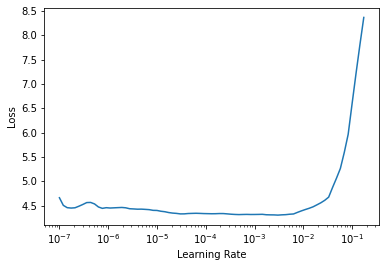

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.161057,3.904099,49.605377,00:34


## Poem Generation Example

In [21]:
prompt = 'love is ridiculous'
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 3])

Adding the `num_beams` and `no_repeat_ngram_size` arguments make a huge difference. This can be explained [here](https://huggingface.co/blog/how-to-generate). Basically beam search reduces the risk of missing hidden high probability word sequences by keeping the most likely num_beams of hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability. Without beam search you will obtain a more greedy search. Beam search will always find an output sequence with higher probability than greedy search, but is not guaranteed to find the most likely output. Moreover, without the `no_repeat_ngram_size` you will likely obtain a repeated output. Thus we add a penalty that makes sure that no n-gram appears twice by manually setting the probability of next words that could create an already seen n-gram to 0.

In [25]:
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
love is ridiculous,
And I am a fool.
I am not a man of the world;
But if I were, I would not be
A fool."
"And what is the matter with you?
You are a liar, and you know
What you are talking about


In [26]:
prompt = "I don't know what I would do"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
I don't know what I would do with my life,
But I know that I am a man of God.
"I am not afraid of death, nor am I afraid to die;
And if I die, I will die with a smile on my face."
He went on
